## Drifters and NOAA data Notebook

### Introduction
This notebook aims to analyze the velocity data from drifters within the tropical Atlantic Ocean. It involves visualizing drifter velocity data, interpolating NOAA data onto drifter data, and comparing the velocities between drifters and NOAA.

### Data Sources
- Drifter Data:
  - Source: NOAA
  - Collection Frequency: Every 6 hours
  - Total Number of Drifters: 221

- NOAA Data:
  - Source: National Oceanic and Atmospheric Administration 
  - Collection Frequency: Every Day
  - Data Product: CoastWatch Caribb-NOAA AOML

### Tasks

#### 1. Visualization of Drifter Velocity Data
- Plot the Eastward (ve) and Northward (vn) velocity as a function of time for a selected drifter.

#### 2. Interpolation of NOAA Data on Drifter Data
- Interpolate CMEMS data onto the time series of the selected drifter data.

#### 3. Comparison between Drifter Velocities and Interpolated CMEMS Velocities
- Visualize the correlation and regression between drifter velocities (ve, vn) and interpolated NOAA between the two datasets.
- Plot time series of both drifter velocities and interpolated CMEMS velocities.

## Import Library


In [66]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from cartopy import config
import matplotlib.animation
from scipy.stats import linregress

## Read Drifter Data


In [67]:
fn='./drifter_6hour_qc_893c_d15d_c4b7_U1711967648742.nc';
ds=xr.open_dataset(fn);

## Extract Coordinates and Variables


In [68]:
ve_curr = ds.ve.values
vn_curr = ds.vn.values
sst = ds.sst.values
lon = ds.longitude.values
lat = ds.latitude.values
time = ds.time.values

## Creation of Pandas Array for Drifter Data


In [69]:
data = {
    'longitude': lon,
    'latitude' : lat,
    'time'     : time,
    've'       : ve_curr,
    'vn'       : vn_curr,
    'sst'      : sst
}

df = pd.DataFrame(data)
df

,longitude,latitude,time,ve,vn,sst
0,-14.478,-18.548,2023-01-01 00:00:00,-0.13760,-0.07635,23.612
1,-14.499,-18.556,2023-01-01 06:00:00,-0.09969,0.01322,23.564
2,-14.519,-18.543,2023-01-01 12:00:00,-0.15719,0.08193,23.699
3,-14.563,-18.524,2023-01-01 18:00:00,-0.26155,0.03533,23.856
4,-14.626,-18.529,2023-01-02 00:00:00,-0.23922,-0.07837,23.717
...,...,...,...,...,...,...
78378,-22.006,-19.946,2023-06-11 12:00:00,-0.03853,-0.05076,25.189
78379,-22.013,-19.961,2023-06-11 18:00:00,-0.05150,-0.06262,25.179
78380,-22.027,-19.971,2023-06-12 00:00:00,-0.06030,-0.04773,25.133
78381,-22.038,-19.980,2023-06-12 06:00:00,-0.06036,-0.05688,25.093


## Selecting Drifter Data


In [70]:
# Test: Our selected drifter has 1102 observations. However, we will limit it to 158 observations because the coordinates 
# of our CMEMS data are 158 in dimension, and the linear interpolation method we use requires it in this situation.

df_1 = df[0:500]
df_1

,longitude,latitude,time,ve,vn,sst
0,-14.478,-18.548,2023-01-01 00:00:00,-0.13760,-0.07635,23.612
1,-14.499,-18.556,2023-01-01 06:00:00,-0.09969,0.01322,23.564
2,-14.519,-18.543,2023-01-01 12:00:00,-0.15719,0.08193,23.699
3,-14.563,-18.524,2023-01-01 18:00:00,-0.26155,0.03533,23.856
4,-14.626,-18.529,2023-01-02 00:00:00,-0.23922,-0.07837,23.717
...,...,...,...,...,...,...
495,-22.450,-17.101,2023-05-04 18:00:00,0.02080,0.00505,26.874
496,-22.443,-17.101,2023-05-05 00:00:00,0.03049,0.02243,26.792
497,-22.437,-17.092,2023-05-05 06:00:00,0.02100,0.03648,26.749
498,-22.435,-17.087,2023-05-05 12:00:00,-0.00296,0.03702,26.820


## Space evolution of Eastward (ve) and Northward (vn) Velocity 

## Case of ve

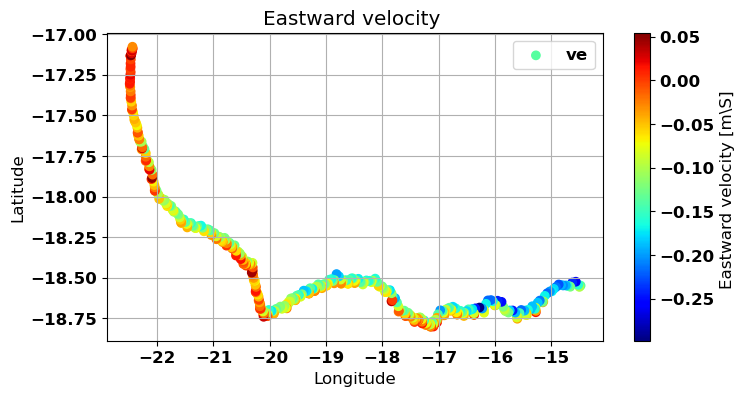

In [71]:
# Assuming you have a DataFrame named df with 'time' and 've' columns

# Plot ve as a function of time
plt.figure(figsize=(8, 4))
plt.scatter(df_1['longitude'], df_1['latitude'], c= df_1['ve'], cmap='jet', marker='o')

# Add title, axis labels, grid and legend
plt.title('Eastward velocity ')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.colorbar(label='Eastward velocity [m\S] ')

plt.legend(['ve'])

# save graphe
plt.savefig("fig7 mode.png")
# Show plot
plt.show()

## Case of vn

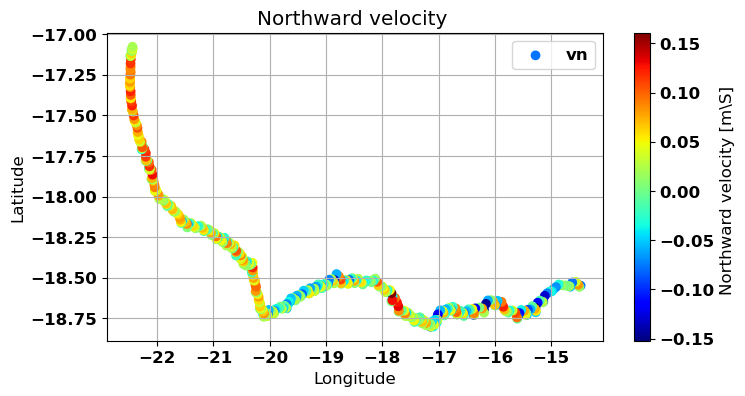

In [72]:
# Assuming you have a DataFrame named df with 'time' and 've' columns

# Plot ve as a function of time
plt.figure(figsize=(8, 4))
plt.scatter(df_1['longitude'], df_1['latitude'], c= df_1['vn'], cmap='jet', marker='o')

# Add title, axis labels, grid and legend
plt.title('Northward velocity ')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.colorbar(label='Northward velocity [m\S] ')

plt.legend(['vn'])

# save graphe
plt.savefig("fig8 mode.png")
# Show plot
plt.show()

## Now let's interpolate the NOAA data onto the grid of the drifter data.

### Case of Geostrophic Velocity Anomalies: Zonal Component (u_current) 


- In this step, we interpolate the ugosa variable from the CMEMS data to the ve variable of the selected drifter.

- We utilize the linear interpolation method for this process. The interpolation is performed based on the variables of longitude, latitude, and important timestamps.

- This allows us to make comparisons and identify differences between drifter variables and CMEMS variables obtained through interpolations.

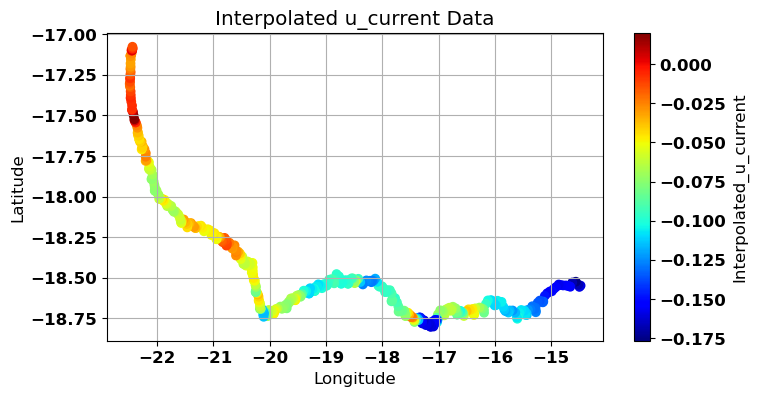

In [73]:
# Chargement des données des bouées dérivantes à partir du DataFrame
df_bouees = df[0:500]   
# Supposez que votre DataFrame contient des colonnes 'temps', 'latitude', 'longitude' et 've'

# Chargement des données satellitaires à partir du fichier netCDF
ds_satellitaires = xr.open_dataset('miamicurrents_f30e_6501_f060.nc')   
# Supposez que vos données satellitaires sont stockées dans une variable appelée 'u_current'

# Extraction des données de courant des bouées
bouees_courant_u = df_bouees['ve']

# Extraction des données de courant satellitaires pour les mêmes positions spatiales et temporelles que les bouées
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellitaires_courant_1 = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['u_current'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_courant_1.append(courant)

# Plot the interpolated data
plt.figure(figsize=(8, 4))
plt.scatter(df_1['longitude'], df_1['latitude'], c= satellitaires_courant_1, cmap='jet', marker='o')

# Add title, axis labels, grid and colorbar
plt.title('Interpolated u_current Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.colorbar(label='Interpolated_u_current')

# save graphe
plt.savefig("fig9 mode.png")
# Show plot
plt.show()

### Case of Geostrophic Velocity Anomalies: Meridional Component (v_current) 

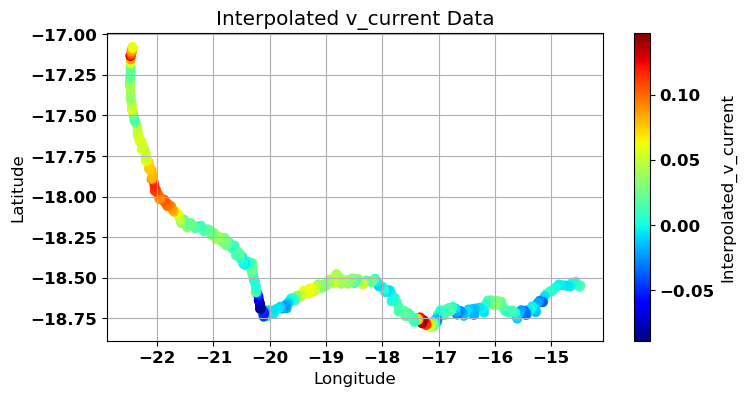

In [74]:
# Chargement des données des bouées dérivantes à partir du DataFrame
df_bouees = df[0:500]   
# Supposez que votre DataFrame contient des colonnes 'temps', 'latitude', 'longitude' et 'vn'

# Chargement des données satellitaires à partir du fichier netCDF
ds_satellitaires = xr.open_dataset('miamicurrents_f30e_6501_f060.nc')   
# Supposez que vos données satellitaires sont stockées dans une variable appelée 'u_current'

# Extraction des données de courant des bouées
bouees_courant_v = df_bouees['vn']

# Extraction des données de courant satellitaires pour les mêmes positions spatiales et temporelles que les bouées
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellitaires_courant_2 = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['v_current'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_courant_2.append(courant)

# Plot the interpolated data
plt.figure(figsize=(8, 4))
plt.scatter(df_1['longitude'], df_1['latitude'], c= satellitaires_courant_2, cmap='jet', marker='o')

# Add title, axis labels, grid and colorbar
plt.title('Interpolated v_current Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.colorbar(label='Interpolated_v_current')

# save graphe
plt.savefig("fig10 mode.png")
# Show plot
plt.show()

## Now Let's Compare Drifter Speeds and  NOAA Speeds

## Comparison between ve and u_current


## Using Regression and Correlation


Corrélation de Pearson: 0.335779325265862
Valeur de p (p-value): 1.2139389286796356e-14


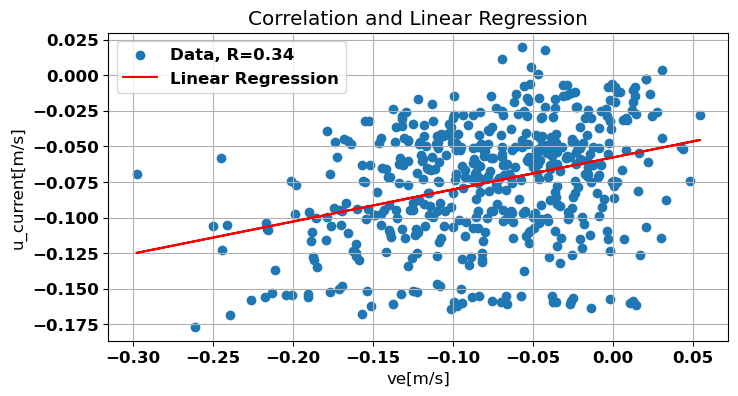

In [76]:
# According to the following, we can simply note that the correlation between "ve" and "ugosa_interpolate" is 0.34. 
# This means that there is a general tendency for the values of the variables to increase together, but this relationship is not very strong.
# Calcul de la corrélation spatiale et temporelle Pearson
correlation, p_value = pearsonr(bouees_courant_u, satellitaires_courant_1)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_u,satellitaires_courant_1)

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_u,satellitaires_courant_1, label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_u, slope*bouees_courant_u + intercept, color='red', label='Linear Regression')
plt.xlabel('ve[m/s]')
plt.ylabel('u_current[m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
plt.savefig("fig11 mode.png")
# Show plot
plt.show()

## Using Time Series

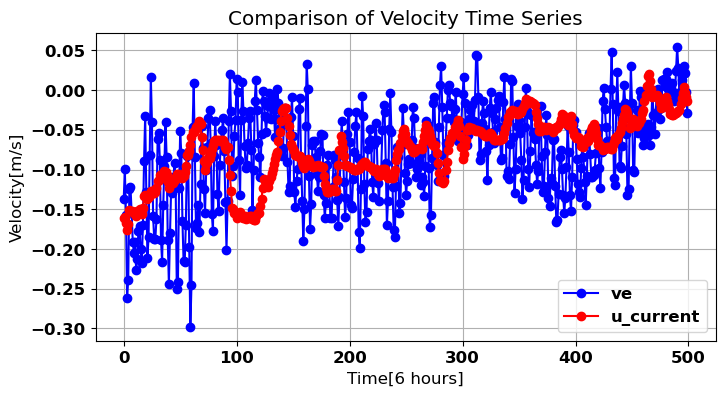

In [77]:
 # Plot time series
plt.figure(figsize=(8, 4))
plt.plot(bouees_courant_u, color='Blue', marker='o', linestyle='-',label='ve')
plt.plot(satellitaires_courant_1, color='RED', marker='o', linestyle='-', label='u_current')
plt.legend([f'Correlation: {correlation:.2f}'], loc='upper left')

# Add title, axis labels, grid and legend 
plt.title('Comparison of Velocity Time Series')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()

# save graphe
# plt.savefig("fig12 mode.png")
# Show plot
plt.show()

### The use of Kalman filter for smoothing $v_e$ and $u_current$

## case of $v_e$

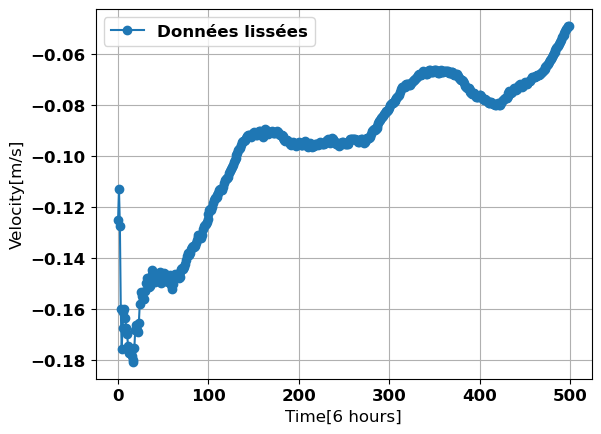

In [79]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Charger la série temporelle
# Supposons que votre série temporelle est dans un array numpy appelé "serie_temporelle"
# Remplacez "serie_temporelle.npy" par le nom de votre fichier contenant la série temporelle
serie_temporelle = bouees_courant_u

# Paramètres du filtre de Kalman
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialiser le filtre de Kalman
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Lisser la série temporelle en utilisant le filtre de Kalman
filtered_values_1 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_1.append(kf.get_latest_estimated_measurement())

# Afficher les données originales et lissées
#plt.plot(df_1['time'],serie_temporelle, marker='o', linestyle='-', label='Données originales')
plt.plot(filtered_values_1, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

## case of $u_current$

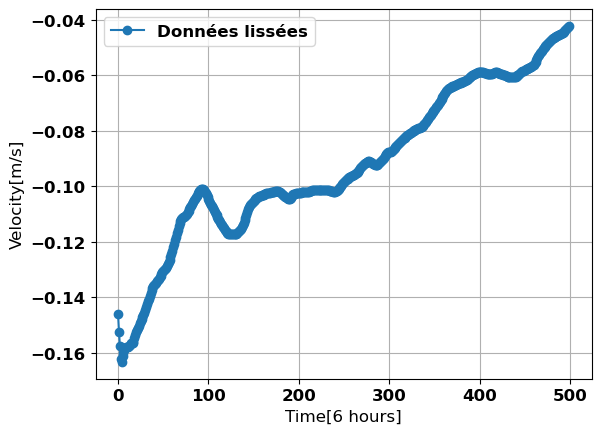

In [80]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Charger la série temporelle
# Supposons que votre série temporelle est dans un array numpy appelé "serie_temporelle"
# Remplacez "serie_temporelle.npy" par le nom de votre fichier contenant la série temporelle
serie_temporelle = satellitaires_courant_1

# Paramètres du filtre de Kalman
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialiser le filtre de Kalman
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Lisser la série temporelle en utilisant le filtre de Kalman
filtered_values_2 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_2.append(kf.get_latest_estimated_measurement())

# Afficher les données originales et lissées
#plt.plot(df_1['time'],serie_temporelle, marker='o', linestyle='-', label='Données originales')
plt.plot(filtered_values_2, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

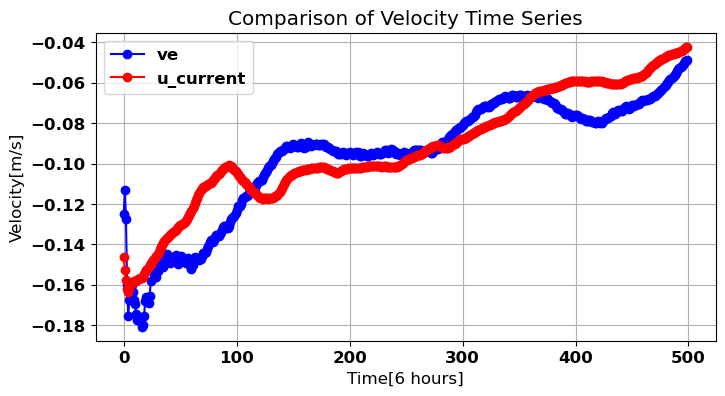

In [81]:
# Plot time series
plt.figure(figsize=(8, 4))
plt.plot(filtered_values_1, color='Blue', marker='o', linestyle='-',label='ve')
plt.plot(filtered_values_2, color='RED', marker='o', linestyle='-', label='u_current')
plt.legend([f'Correlation: {correlation:.2f}'], loc='upper left')

# Add title, axis labels, grid and legend 
plt.title('Comparison of Velocity Time Series')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()

# save graphe
plt.savefig("fig12 mode.png")
# Show plot
plt.show()

## Comparison between vn and v_current


## Using Regression and Correlation

Corrélation de Pearson: 0.13877557161956802
Valeur de p (p-value): 0.001868262385194133


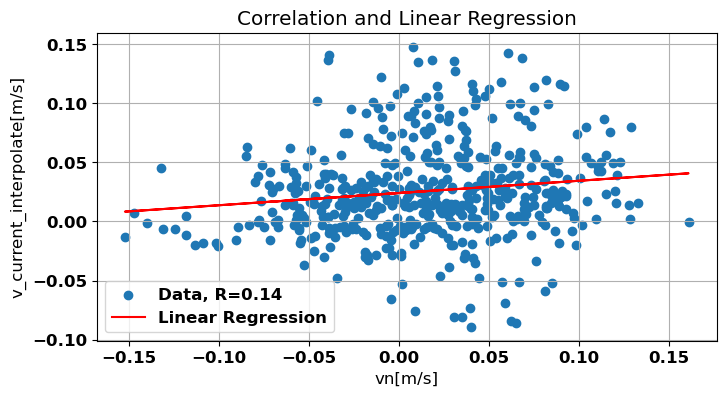

In [82]:
# According to the following, we can simply note that the correlation between "ve" and "ugosa_interpolate" is 0.14. 
# This suggests that there is a general tendency for the values of the variables to increase together, but this relationship is rather weak.
# Calcul de la corrélation spatiale et temporelle Pearson
correlation, p_value = pearsonr(bouees_courant_v, satellitaires_courant_2)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_v,satellitaires_courant_2)

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_v,satellitaires_courant_2, label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_v, slope*bouees_courant_v + intercept, color='red', label='Linear Regression')
plt.xlabel('vn[m/s]')
plt.ylabel('v_current_interpolate[m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
plt.savefig("fig13 mode.png")
# Show plot
plt.show()

## Using Time Series

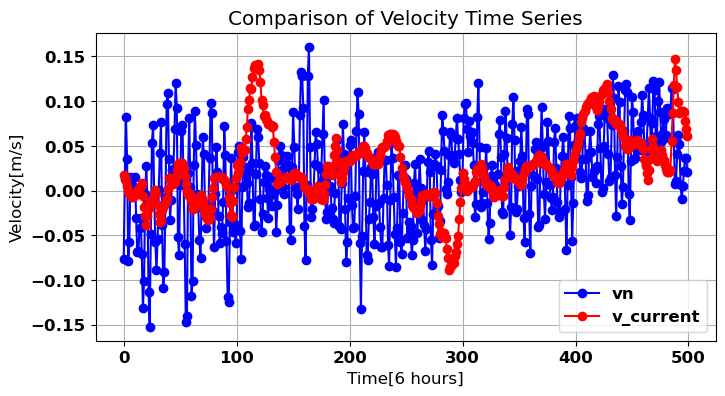

In [83]:
 # Plot time series
plt.figure(figsize=(8, 4))
plt.plot(bouees_courant_v, color='Blue', marker='o', linestyle='-',label='vn')
plt.plot(satellitaires_courant_2, color='RED', marker='o', linestyle='-', label='v_current')
plt.legend([f'Correlation: {correlation:.2f}'], loc='upper left')

# Add title, axis labels, grid and legend 
plt.title('Comparison of Velocity Time Series')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()

# save graphe
# plt.savefig("fig12 mode.png")
# Show plot
plt.show()

### The use of Kalman filter for smoothing $v_n$ and $v_current$

## case of $v_n$

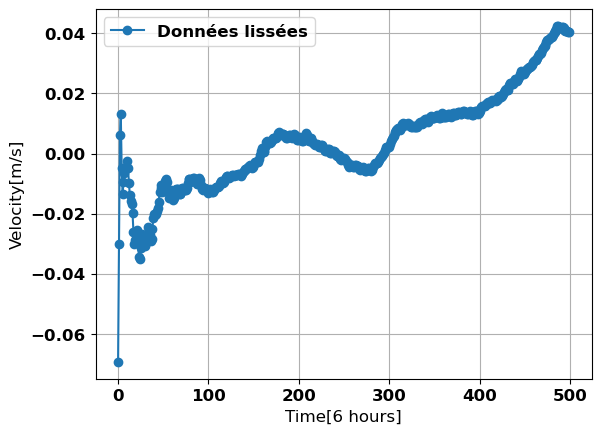

In [84]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Charger la série temporelle
# Supposons que votre série temporelle est dans un array numpy appelé "serie_temporelle"
# Remplacez "serie_temporelle.npy" par le nom de votre fichier contenant la série temporelle
serie_temporelle = bouees_courant_v

# Paramètres du filtre de Kalman
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialiser le filtre de Kalman
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Lisser la série temporelle en utilisant le filtre de Kalman
filtered_values_3 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_3.append(kf.get_latest_estimated_measurement())

# Afficher les données originales et lissées
#plt.plot(df_1['time'],serie_temporelle, marker='o', linestyle='-', label='Données originales')
plt.plot(filtered_values_3, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

## case of $v_current$

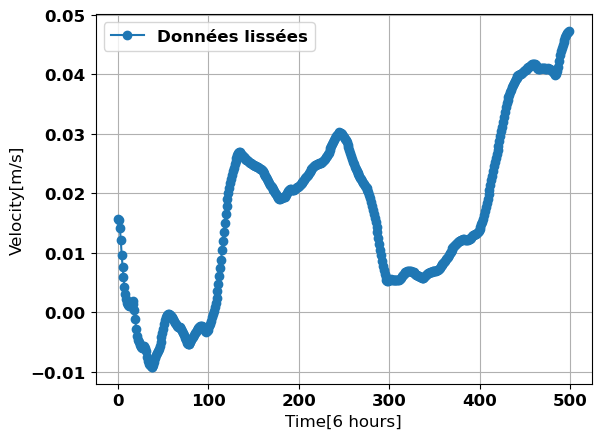

In [85]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Charger la série temporelle
# Supposons que votre série temporelle est dans un array numpy appelé "serie_temporelle"
# Remplacez "serie_temporelle.npy" par le nom de votre fichier contenant la série temporelle
serie_temporelle = satellitaires_courant_2

# Paramètres du filtre de Kalman
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialiser le filtre de Kalman
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Lisser la série temporelle en utilisant le filtre de Kalman
filtered_values_4 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_4.append(kf.get_latest_estimated_measurement())

# Afficher les données originales et lissées
#plt.plot(df_1['time'],serie_temporelle, marker='o', linestyle='-', label='Données originales')
plt.plot(filtered_values_4, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

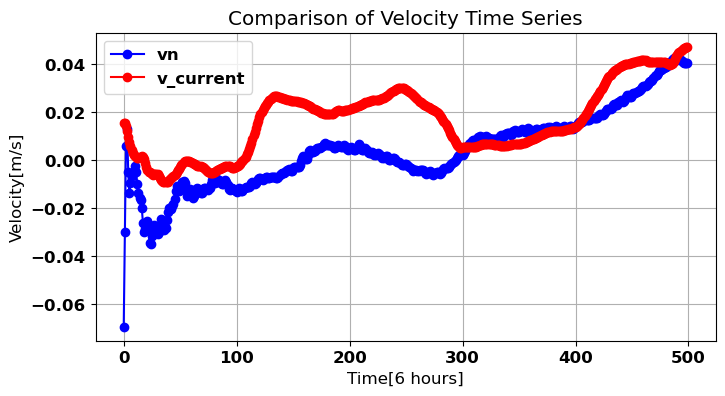

In [86]:
 # Plot time series
plt.figure(figsize=(8, 4))
plt.plot(filtered_values_3, color='Blue', marker='o', linestyle='-',label='vn')
plt.plot(filtered_values_4, color='RED', marker='o', linestyle='-', label='v_current')
plt.legend([f'Correlation: {correlation:.2f}'], loc='upper left')

# Add title, axis labels, grid and legend 
plt.title('Comparison of Velocity Time Series')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()

# save graphe
plt.savefig("fig14 mode.png")
# Show plot
plt.show()

## Conclusion
 - Moderate relationship between the variables u_current (NOAA Current) and ve (Drifter Current).
 - Weak relationship  between v_current (NOAA Current) and vn (Drifter Current).
 - Meridional Ekman current stronger than zonal Ekman current.
 - Surface currents are difficult to measure both by satellite products represented here by the "NOAA" currents and by drifting buoys represented here by the "Drifter" currents. The difference may be due to inertial or Ekman oscillations, primarily. These assumptions will be the subject of our upcoming notebooks.